In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kaggle_hm.utils import init_nb

init_nb()

In [2]:
c = pd.read_parquet('../data/clean/customers.parquet')

sample = c.sample(n=250, random_state=1)
items = pd.read_parquet('../data/clean/articles.parquet')
t = pd.read_parquet('../data/clean/transactions.parquet')
t = t[t['customer_id'].isin(sample['customer_id'])]
t_ext = t.merge(items[['article_id', 'prod_name', 'product_group_name', 'perceived_colour_master_name', 'index_name', 'product_type_name']])
t_ext['dow'] = t_ext['t_dat'].dt.dayofweek.map({0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"})

In [28]:
customer = sample.iloc[3]['customer_id']

print(sample.iloc[3])

t_ext[t_ext['customer_id'] == customer][['t_dat', 'dow', 'price', 'prod_name', 'product_type_name', 'product_group_name', 'index_name', 'perceived_colour_master_name', 'sales_channel_id']].sort_values('t_dat')

customer_id               bb455bc38400bd6902f9bea828df555a3d55818fcb144b...
FN                                                                    1.000
Active                                                                1.000
club_member_status                                                   ACTIVE
fashion_news_frequency                                            Regularly
age                                                                  54.000
postal_code               1d98a184bc258bf41ea61b66cdcc46bc5c05c2d982c38e...
Name: 1003611, dtype: object


,t_dat,dow,price,prod_name,product_type_name,product_group_name,index_name,perceived_colour_master_name,sales_channel_id
507,2020-05-18,Mon,0.034,Jade HW Skinny Denim TRS,Trousers,Garment Lower body,Divided,Blue,2
646,2020-05-18,Mon,0.012,Claudine rib t-shirt,T-shirt,Garment Upper body,Ladieswear,Black,2
647,2020-05-18,Mon,0.017,Brittany LS,Top,Garment Upper body,Divided,Black,2
648,2020-05-18,Mon,0.017,Brittany LS,Top,Garment Upper body,Divided,Black,2
649,2020-05-18,Mon,0.025,All That Jazz Push Up Bra,Bikini top,Swimwear,Lingeries/Tights,White,2
688,2020-08-12,Wed,0.042,Tinos mesh tights,Leggings/Tights,Garment Lower body,Sport,Black,2
689,2020-08-12,Wed,0.042,HAVANA HW tights,Unknown,Unknown,Sport,Black,2


Let's explore basic characteristics of sales

In [3]:
t_ext.shape

(6480, 11)

In [94]:
t_ext['product_type_name'].value_counts(normalize=True)[:20].sum()

0.8771604938271605

To keep charts readable let's limit data to top-20 products, they account for 87% of items sold.

In [187]:
season_map = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
t_ext['season'] = t_ext['t_dat'].dt.month.map(season_map)

top_prods = set(
    t_ext['product_type_name'].value_counts()[:20].index
)

top_t = t_ext[t_ext['product_type_name'].isin(top_prods)]

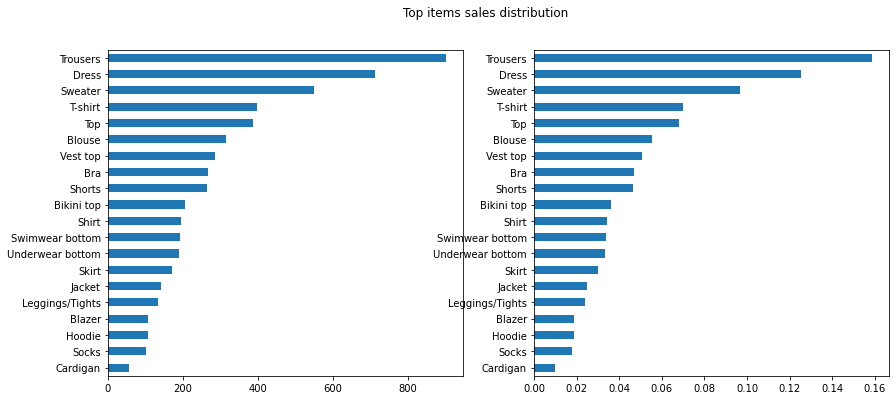

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

top_t['product_type_name'].value_counts().sort_values().plot.barh(ax=ax[0])
top_t['product_type_name'].value_counts(normalize=True).sort_values().plot.barh(ax=ax[1])

plt.suptitle('Top items sales distribution');

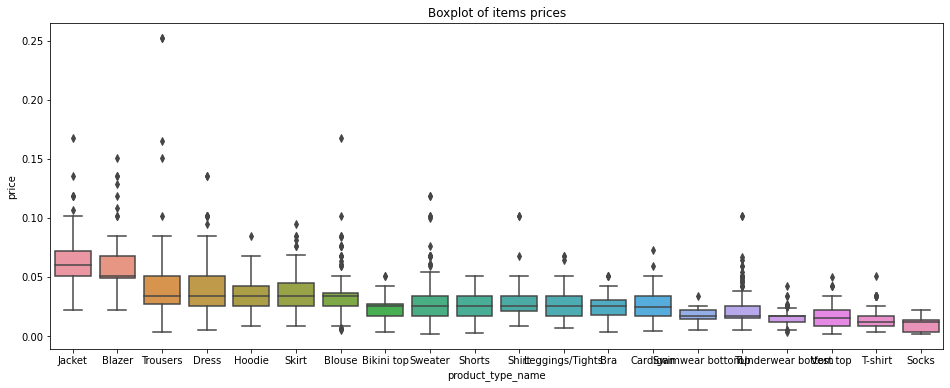

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
_ = list(top_t.groupby('product_type_name')['price'].median().sort_values(ascending=False).index)
sns.boxplot(data=top_t, x='product_type_name', y='price', order=_)
ax.set(title='Boxplot of items prices');

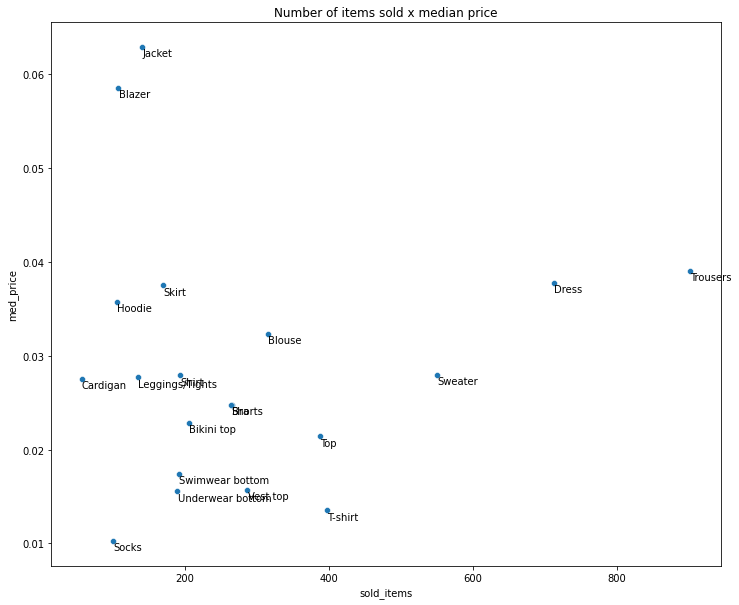

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
_ = top_t.groupby('product_type_name').agg(sold_items=('article_id', 'count'), med_price=('price', 'mean'))

sns.scatterplot(data=_, x='sold_items', y='med_price', ax=ax)

for line in range(0, _.shape[0]):
     ax.text(_.iloc[line]['sold_items']+0.2, _.iloc[line]['med_price']-.001, _.iloc[line].name, horizontalalignment='left', size='medium', color='black')
plt.title('Number of items sold x median price');

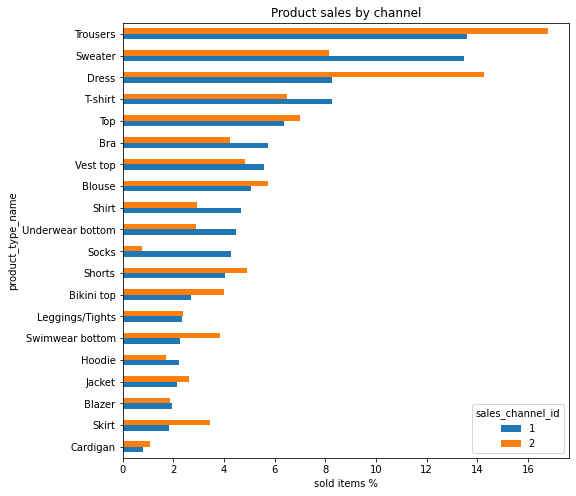

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
(pd.crosstab(
    top_t['product_type_name'],
    top_t['sales_channel_id'],
    top_t['article_id'],
    aggfunc='count',
    normalize='columns'
).sort_values(1) * 100).plot.barh(ax=ax)

ax.set(title='Product sales by channel', xlabel='sold items %');

Customers are more likely to buy socks, sweaters at brick shop? (why?)
On the other side, they are more likely to buy a dress online?

In [97]:
# todo: top-items per index (need more data)

In [101]:
top_colors = (
    top_t['perceived_colour_master_name'].value_counts().sort_values(ascending=False)[:12]
)

top_colors = set(top_colors.index)

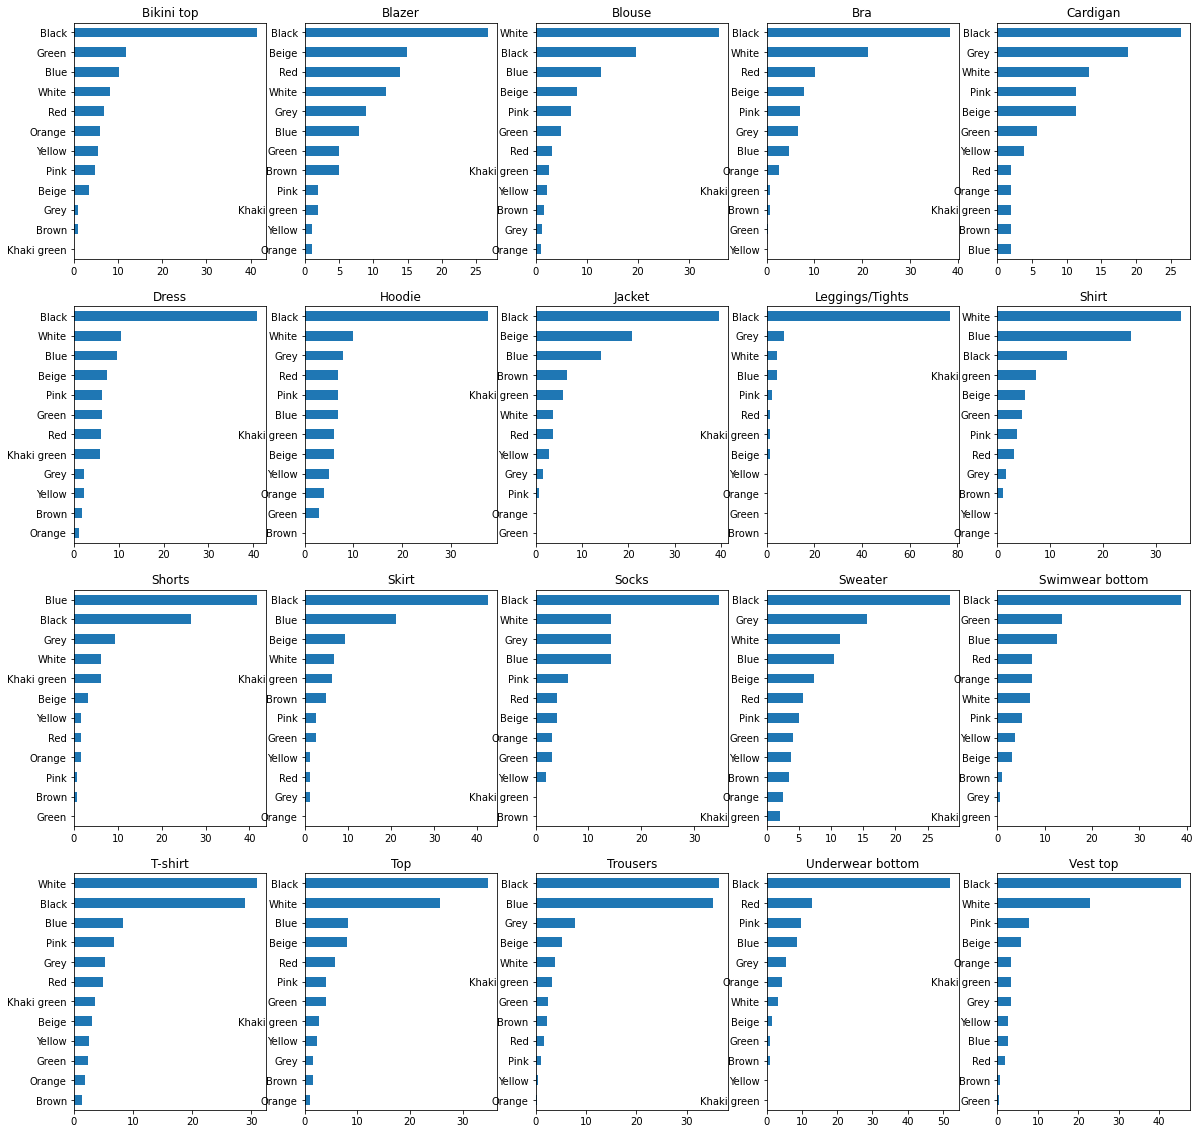

In [142]:
fig, ax = plt.subplots(4, 5, figsize=(20, 20))
_ = top_t[top_t['perceived_colour_master_name'].isin(top_colors)]
ct = pd.crosstab(
    _['product_type_name'],
    _['perceived_colour_master_name'],
    normalize='index'
) * 100

for i, prod in enumerate(ct.index):
    row, col = i // 5, i % 5
    ct.loc[prod].sort_values().plot.barh(ax=ax[row, col])
    ax[row, col].set(title=f'{prod}', ylabel='')

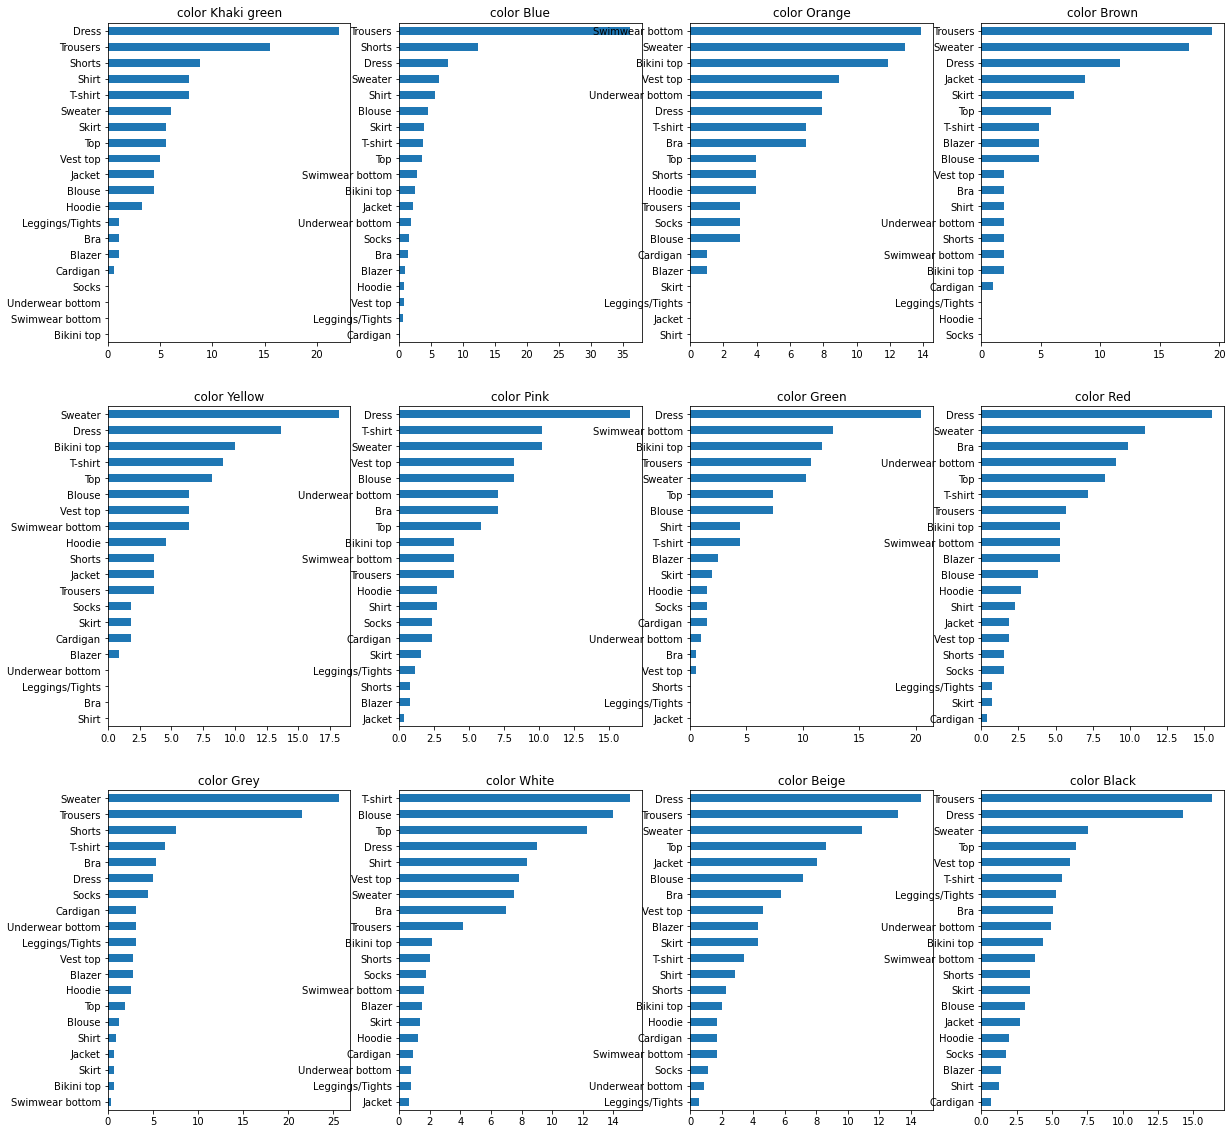

In [123]:
fig, ax = plt.subplots(3, 4, figsize=(20, 20))
_ = top_t[top_t['perceived_colour_master_name'].isin(top_colors)]
ct = pd.crosstab(
    _['product_type_name'],
    _['perceived_colour_master_name'],
    normalize='columns'
) * 100

for i, color in enumerate(top_colors):
    row, col = i // 4, i % 4
    ct[color].sort_values().plot.barh(ax=ax[row, col])
    ax[row, col].set(title=f'color {color}', ylabel='')

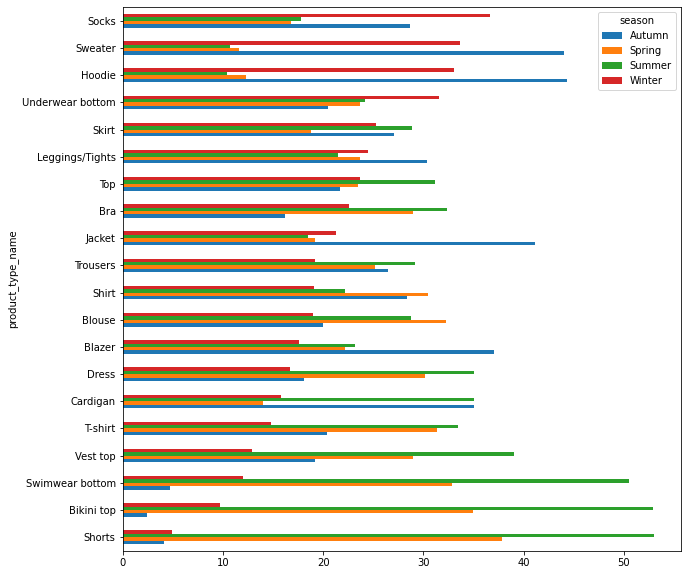

In [186]:
_ = pd.crosstab(
    top_t['product_type_name'],
    top_t['season'],
    normalize='index'
) * 100

_.sort_values('Winter', ascending=True).plot.barh(figsize=(10, 10));

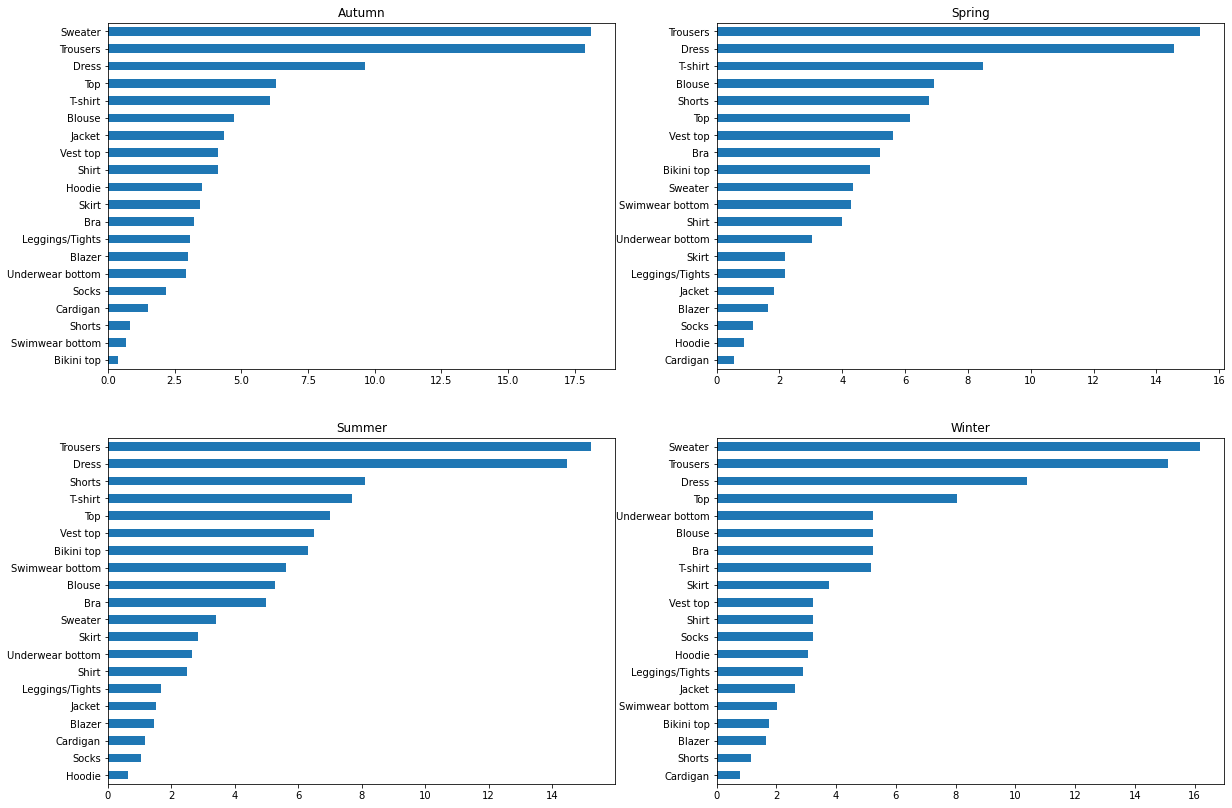

In [174]:
fig, ax = plt.subplots(2, 2, figsize=(20, 14))

_ = pd.crosstab(
    top_t['season'],
    top_t['product_type_name'],
    normalize='index'
) * 100

for i, season in enumerate(_.index):
    row, col = i // 2, i % 2
    _.loc[season].sort_values().plot.barh(ax=ax[row, col])
    ax[row, col].set(title=f'{season}', ylabel='')

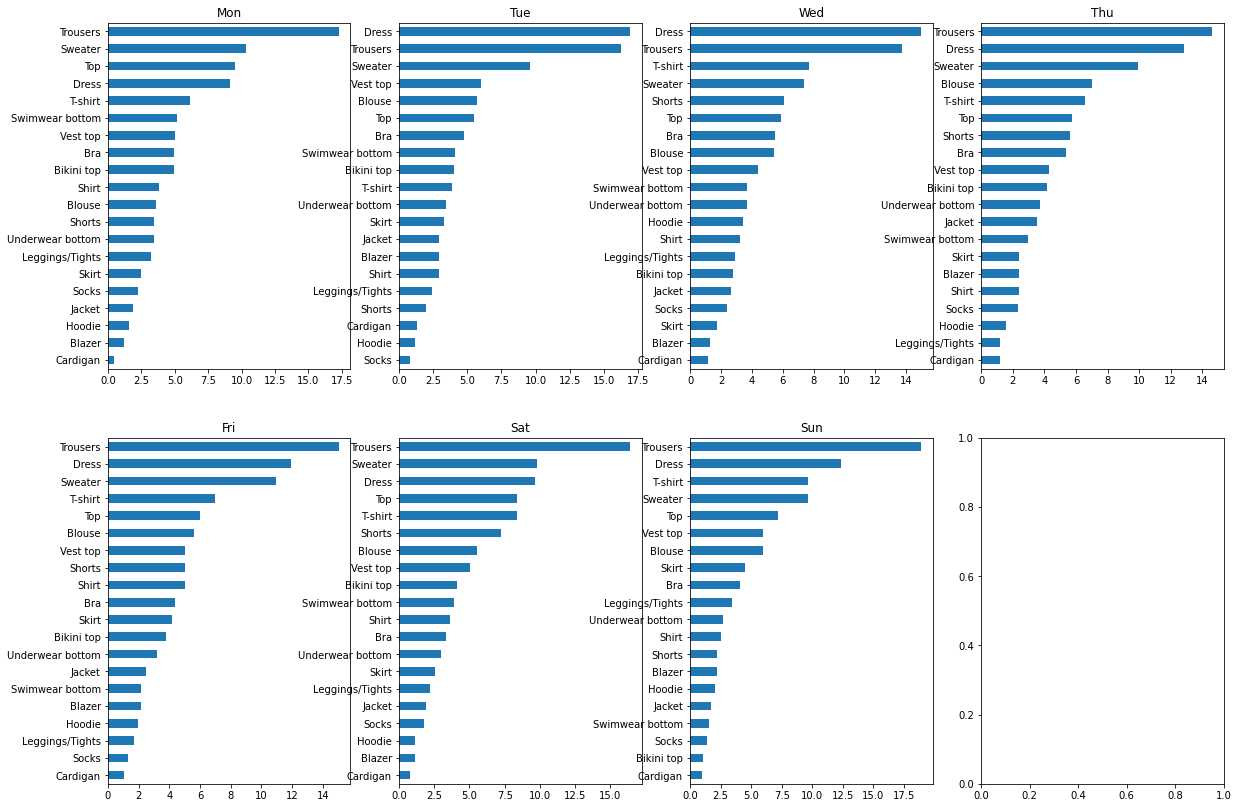

In [191]:
fig, ax = plt.subplots(2, 4, figsize=(20, 14))

_ = (pd.crosstab(
    top_t['dow'],
    top_t['product_type_name'],
    normalize='index'
) * 100).loc[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]

# use odds-ratio to sort values? Pr(item|dow=Monday)/Pr(item)? log2(ODDS)?

for i, season in enumerate(_.index):
    row, col = i // 4, i % 4
    _.loc[season].sort_values().plot.barh(ax=ax[row, col])
    ax[row, col].set(title=f'{season}', ylabel='')

In [199]:
(pd.crosstab(
    top_t['dow'],
    top_t['product_type_name'],
    normalize='index'
) * 100).loc[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].T.apply(lambda _: _ / (top_t['product_type_name'].value_counts(normalize=True) * 100))

dow,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Bikini top,1.363,1.102,0.763,1.153,1.037,1.139,0.302
Blazer,0.650,1.542,0.667,1.274,1.131,0.611,1.151
Blouse,0.644,1.030,0.974,1.266,1.005,0.998,1.068
Bra,1.055,1.024,1.182,1.152,0.941,0.717,0.868
Cardigan,0.492,1.328,1.149,1.207,1.071,0.772,0.935
Dress,0.728,1.348,1.194,1.026,0.950,0.771,0.984
Hoodie,0.861,0.643,1.853,0.826,1.037,0.623,1.089
Jacket,0.747,1.181,1.068,1.419,0.996,0.780,0.693
Leggings/Tights,1.351,1.009,1.213,0.510,0.724,0.924,1.447
Shirt,1.121,0.858,0.945,0.709,1.479,1.059,0.732


<AxesSubplot:>

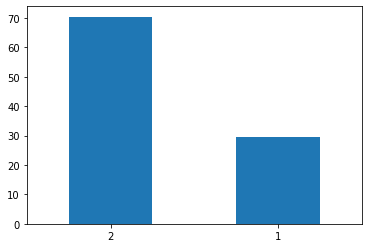

In [4]:
(t_ext['sales_channel_id'].value_counts(normalize=True) * 100).plot.bar(rot=0)

<AxesSubplot:>

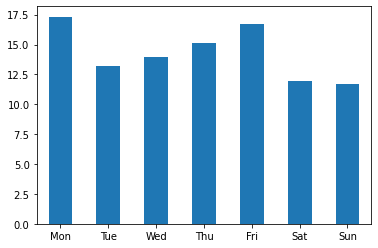

In [60]:
(t_ext['dow'].value_counts(normalize=True) * 100).loc[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].plot.bar(rot=0)

In [46]:
t_ext['perceived_colour_master_name'].value_counts(normalize=True) * 100

Black          41.163
Blue           13.895
White          12.442
Beige           5.872
Grey            5.000
Red             3.895
Pink            3.372
Brown           2.500
Green           2.384
Khaki green     2.151
Yellow          1.686
Orange          1.279
Unknown         1.163
Turquoise       1.105
Mole            1.105
Metal           0.640
Lilac Purple    0.349
Name: perceived_colour_master_name, dtype: float64

In [47]:
t_ext['product_group_name'].value_counts(normalize=True) * 100

Garment Upper body   39.884
Garment Lower body   24.826
Garment Full body    10.407
Underwear             9.593
Swimwear              6.919
Accessories           3.256
Shoes                 2.907
Socks & Tights        1.279
Nightwear             0.640
Unknown               0.233
Bags                  0.058
Name: product_group_name, dtype: float64

In [48]:
t_ext['index_name'].value_counts(normalize=True) * 100

Ladieswear                       42.965
Divided                          25.988
Lingeries/Tights                 15.116
Sport                             5.581
Ladies Accessories                4.593
Menswear                          3.023
Children Sizes 134-170            1.221
Baby Sizes 50-98                  0.756
Children Sizes 92-140             0.698
Children Accessories, Swimwear    0.058
Name: index_name, dtype: float64

In [53]:
t_ext['product_type_name'].value_counts(normalize=True) * 100

Trousers                   15.872
Dress                       9.826
Sweater                     8.430
Top                         6.221
T-shirt                     5.988
Bra                         5.814
Vest top                    5.698
Shorts                      4.360
Bikini top                  3.372
Underwear bottom            3.140
Blouse                      3.140
Jacket                      2.733
Swimwear bottom             2.733
Leggings/Tights             2.616
Hoodie                      2.035
Skirt                       1.919
Shirt                       1.453
Blazer                      1.279
Socks                       0.988
Cardigan                    0.872
Coat                        0.872
Bodysuit                    0.756
Boots                       0.698
Wedge                       0.640
Swimsuit                    0.523
Belt                        0.465
Jumpsuit/Playsuit           0.465
Bag                         0.407
Underwear body              0.407
Sneakers      